In [1]:
# !rm -rf IMG

Google Colab Notebook

In [2]:
!pip install numpy pandas matplotlib opencv-python opencv-contrib-python scikit-learn tensorflow keras

Data Pre-Processing

In [3]:
!unzip /content/IMG.zip -d /content

Archive:  /content/IMG.zip
replace /content/IMG/center_2025_12_07_19_21_36_302.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, Input, BatchNormalization, Flatten, Dense, Dropout
from keras.optimizers import Adam
import tensorflow as tf

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
print("GPU:", physical_devices)
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [6]:
df = pd.read_csv(
    os.path.join("/content", "driving_log.csv"),
    names=["center", "left", "right", "steering", "throttle", "brake", "speed"]
)
df.iloc[:, :3] = df.iloc[:, :3].apply(lambda x: os.path.join("/content/IMG", x[0].split("\\")[-1]))
data = df[["center", "steering"]]

In [7]:
def plot_hist(data, limit = 10000):
  plt.hist(data["steering"], bins=30)
  plt.ylim(0, limit)
  plt.xlim(-1, 1)
  plt.xlabel("Steering Angle")
  plt.ylabel("Frequency")
  plt.title("Histogram of Sample Data")
  plt.show()

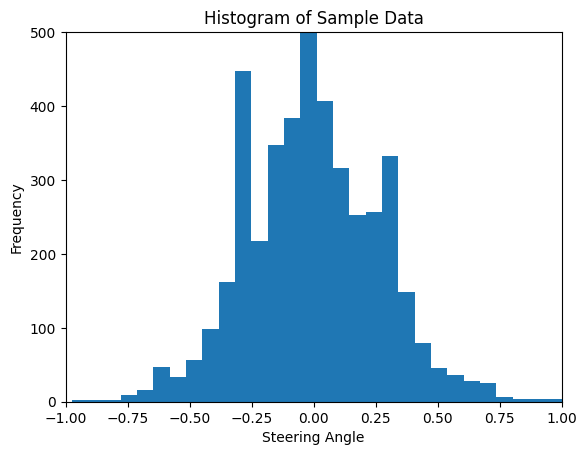

In [8]:
plot_hist(data, limit=500)

Downsample the majority

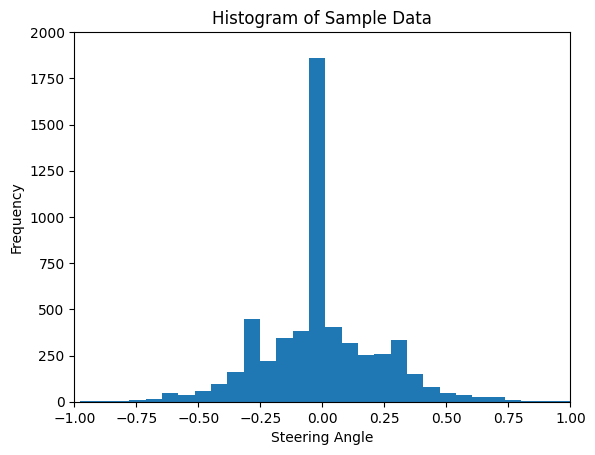

In [9]:
target_count = 1500

data_majority = data[data['steering'].between(-0.01, 0.01, inclusive="neither")]
data_minority = data[~data['steering'].between(-0.01, 0.01, inclusive="neither")]

data_majority_downsampled = data_majority.sample(n=target_count, random_state=42)

data_balanced = pd.concat([data_majority_downsampled, data_minority])
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

plot_hist(data_balanced, limit=2000)

In [10]:
def pre_process_data(data):
  images, steering_angles = [], []
  for img_path, steering_angle in data.values:
    img = cv2.imread(img_path)
    img = img[60:135, :]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img = cv2.resize(img, (200, 66))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = img / 255.0
    images.append(img)
    steering_angles.append(steering_angle)
  return np.array(images), np.array(steering_angles)

In [11]:
def augment_trainig_data(images, steering_angles):
  aug_images, aug_steering_angles = [], []
  for image, steering_angle in zip(images, steering_angles):
    aug_images.append(image)
    aug_steering_angles.append(steering_angle)

    aug_type = np.random.randint(4)

    aug_image = image
    aug_steering_angle = steering_angle

    if aug_type == 0: # Flipping
      aug_image = cv2.flip(image, 1)
      aug_steering_angle = -steering_angle

    elif aug_type == 1 : # Brightness adjustment
      img_rgb = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_YUV2RGB)
      hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

      brightness_factor = np.random.uniform(0.25, 1.5)
      hsv[:, :, 2] = np.clip(hsv[:, :, 2] * brightness_factor, 0, 255)

      aug_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
      aug_image = cv2.cvtColor(aug_image, cv2.COLOR_RGB2YUV)
      aug_image = aug_image.astype(np.float32) / 255.0

    elif aug_type == 2: # Zooming
      zoom_range = 0.2
      h, w, _ = image.shape
      zoom_factor = 1 + (np.random.rand() - 0.5) * zoom_range
      new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)

      if new_h <= 0 or new_w <= 0:
          new_h, new_w = h, w

      start_h = np.random.randint(0, max(1, h - new_h))
      start_w = np.random.randint(0, max(1, w - new_w))
      cropped_image = image[start_h:start_h + new_h, start_w:start_w + new_w]
      aug_image = cv2.resize(cropped_image, (w, h))

    elif aug_type == 3: # Rotation
      max_angle = 15
      angle = np.random.uniform(-max_angle, max_angle)
      rows, cols, _ = image.shape
      M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
      aug_image = cv2.warpAffine(image, M, (cols, rows))
      aug_steering_angle = steering_angle + angle / max_angle * 0.1

    aug_images.append(aug_image)
    aug_steering_angles.append(aug_steering_angle)

  return np.array(aug_images), np.array(aug_steering_angles)

In [21]:
X, y = pre_process_data(data_balanced)

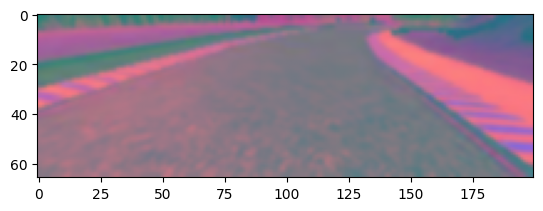

In [13]:
plt.figure()
plt.imshow(X[0])
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
del X, y

X_train, y_train = augment_trainig_data(X_train, y_train)

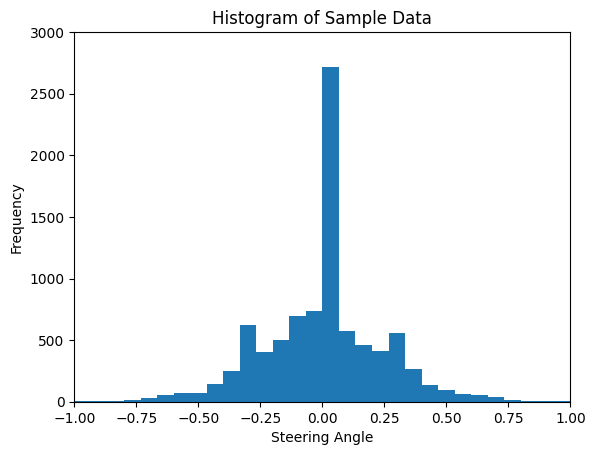

In [15]:
plot_hist(pd.DataFrame(y_train, columns=["steering"]), limit=3000)

In [16]:
def plot_training_history(history):
  plt.figure()
  history = history.history
  plt.plot(history["loss"], label="Training Loss")
  plt.plot(history["val_loss"], label="Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

In [33]:
def train_model(X_train, X_test, y_train, y_test, epochs = 10, batch_size = 32, model_name = "model.h5"):

  model = Sequential([
        Input(shape=(66, 200, 3)),
        BatchNormalization(),
        Conv2D(filters=24, kernel_size=(5, 5), strides=(2, 2), activation='elu'),
        Conv2D(filters=36, kernel_size=(5, 5), strides=(2, 2), activation='elu'),
        Conv2D(filters=48, kernel_size=(5, 5), strides=(2, 2), activation='elu'),
        Conv2D(filters=64, kernel_size=(3, 3), activation='elu'),
        Conv2D(filters=64, kernel_size=(3, 3), activation='elu'),
        Flatten(),
        Dense(1164, activation='elu'),
        Dense(100, activation='elu'),
        Dense(50, activation='elu'),
        Dense(10, activation='elu'),
        Dense(1)
    ])

  optimizer = Adam(learning_rate=1e-4)

  model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=1)
  model.save(model_name)
  return history

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0919 - mae: 0.2159 - val_loss: 0.0567 - val_mae: 0.1681
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0549 - mae: 0.1687 - val_loss: 0.0560 - val_mae: 0.1650
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0554 - mae: 0.1681 - val_loss: 0.0563 - val_mae: 0.1695
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0573 - mae: 0.1702 - val_loss: 0.0561 - val_mae: 0.1635
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0548 - mae: 0.1663 - val_loss: 0.0566 - val_mae: 0.1676
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0551 - mae: 0.1665 - val_loss: 0.0563 - val_mae: 0.1695
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0556 - mae: 0.1671 - val_loss: 0.0563 - val_mae: 0.1654
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0526 - mae: 0.1623 - val_loss: 0.0564 - val_mae: 0.1657
Epoch 9/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms

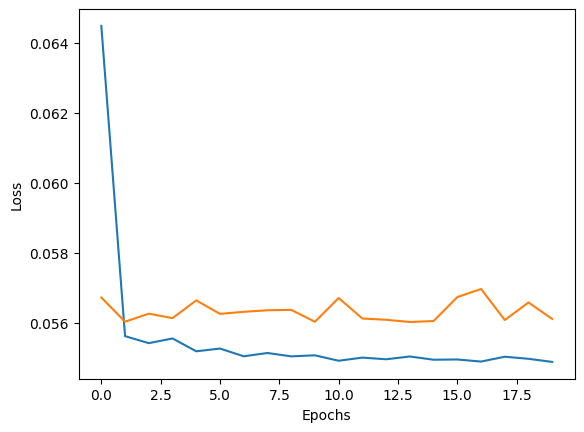

In [34]:

history = train_model(X_train, X_test, y_train, y_test, epochs=20, batch_size=32)
plot_training_history(history)

In [19]:
del X_train, X_test, y_train, y_test